In [50]:
import do_mpc
import numpy as np
from casadi import *

In [51]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

#Set state, input and parameters
V = model.set_variable(var_type='_x', var_name='V', shape=(1,1))
I = model.set_variable(var_type='_x', var_name='I', shape=(1,1))
G_in = model.set_variable(var_type='_u', var_name='G', shape=(1,1))
T_in = model.set_variable(var_type='_u', var_name='T', shape=(1,1))

G = 2000
T = 55

In [52]:
# Definizione dei parametri del modello
Isc = 8.21  # Corrente di cortocircuito [A]
Gref = 1000  # Irradianza solare di riferimento [W/m^2]
alpha = 0.0005  # Coefficiente di temperatura della corrente di cortocircuito [1/°C]
Tref = 298.15  # Temperatura di riferimento [K]
I0 = 1.6e-9  # Corrente di saturazione inversa del diodo [A]
q = 1.60217662e-19  # Carica dell'elettrone [C]
k = 1.380649e-23  # Costante di Boltzmann [J/K]
Rs = 0.015  # Resistenza serie [Ohm]
Rp = 1000  # Resistenza parallela [Ohm]
Voc = 48.5  # Tensione a circuito aperto [V]

# Definizione dei parametri del problema di ottimizzazione
G = 500  # Irradianza solare [W/m^2]
T = 25  # Temperatura del pannello fotovoltaico [K]
t_sim = 10  # Tempo di simulazione [s]
dt = 0.1  # Intervallo di campionamento [s]

In [53]:
Iph = Isc * (G_in/Gref) * (1 + alpha * (T_in - Tref))
Id = I0 * (np.exp((q*V)/(k*T_in)) - 1)

model.set_rhs('V', Voc - Rs*I - Rp*Iph)
model.set_rhs('I', Iph - Id)

model.setup()

In [54]:
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 0,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

# Define the cost function
P = -I*V
mterm = -I*V
mpc.set_objective(lterm=P, mterm=mterm)

# Bounds on state:
mpc.bounds['lower','_x', 'I'] = 0
mpc.bounds['upper','_x', 'I'] = 21

mpc.bounds['lower','_x', 'V'] = 0
mpc.bounds['upper','_x', 'V'] = 59.4

# Bounds on input:
mpc.bounds['lower','_u', 'G'] = 500
mpc.bounds['upper','_u', 'G'] = 4500

mpc.bounds['lower','_u', 'T'] = 25
mpc.bounds['upper','_u', 'T'] = 75

mpc.setup()

In [55]:
simulator = do_mpc.simulator.Simulator(model)

simulator.set_param(t_step = 0.1)
simulator.setup()

x0 = np.pi*np.array([0, 0]).reshape(-1,1)

simulator.x0 = x0
mpc.x0 = x0

mpc.set_initial_guess()

CasADi -  WARNING("simulator:odeF failed: NaN detected for output ode, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("simulator:odeF failed: NaN detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("simulator:odeF failed: NaN detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("simulator:odeF failed: NaN detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("simulator:odeF failed: NaN detected for output ode, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("simulator:jacF failed: Inf detected for output o0, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:265]
psetup failed: .../casadi/interfaces/sundials/cvodes_interface.cpp:650: 'jacF' calculation failed
CasADi -  WARNING("simulator:odeF failed: NaN detected for output ode, at (row 0, col 0).") [.../ca

RuntimeError: .../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_CONV_FAILURE". Consult CVODES documentation.

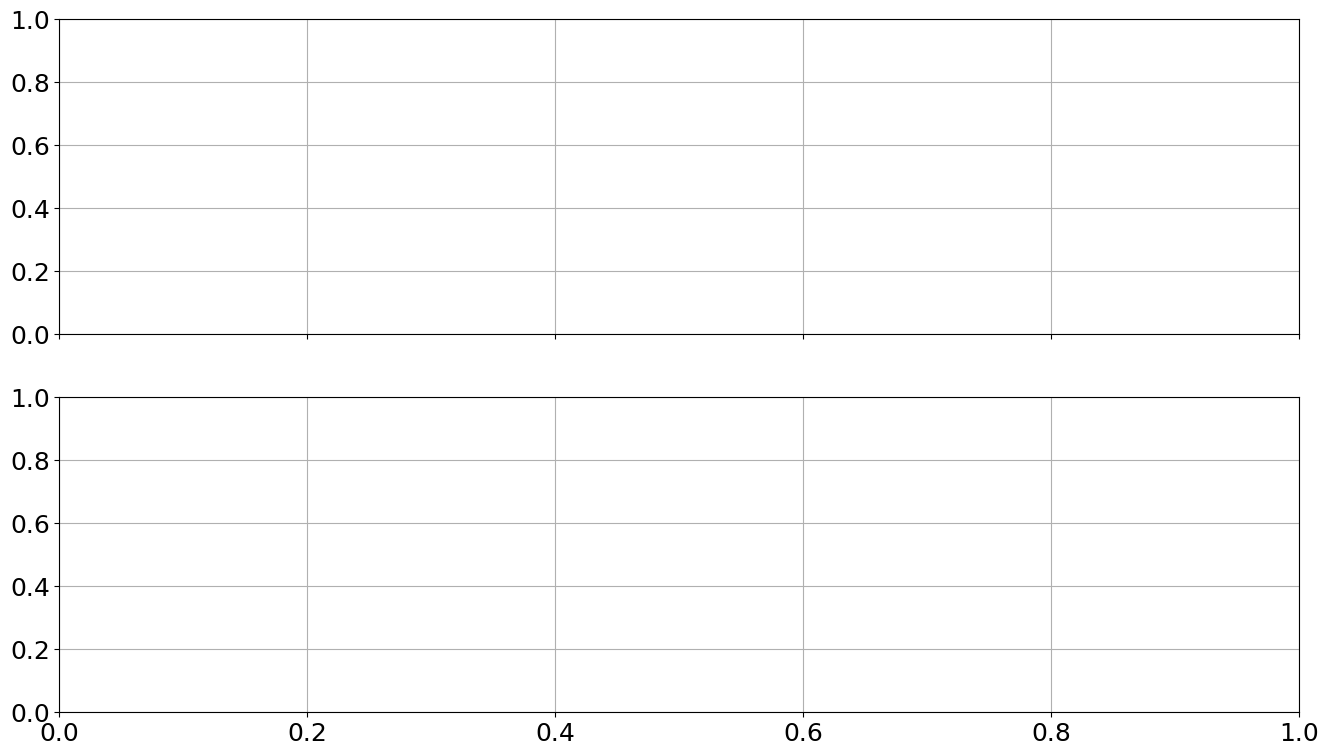

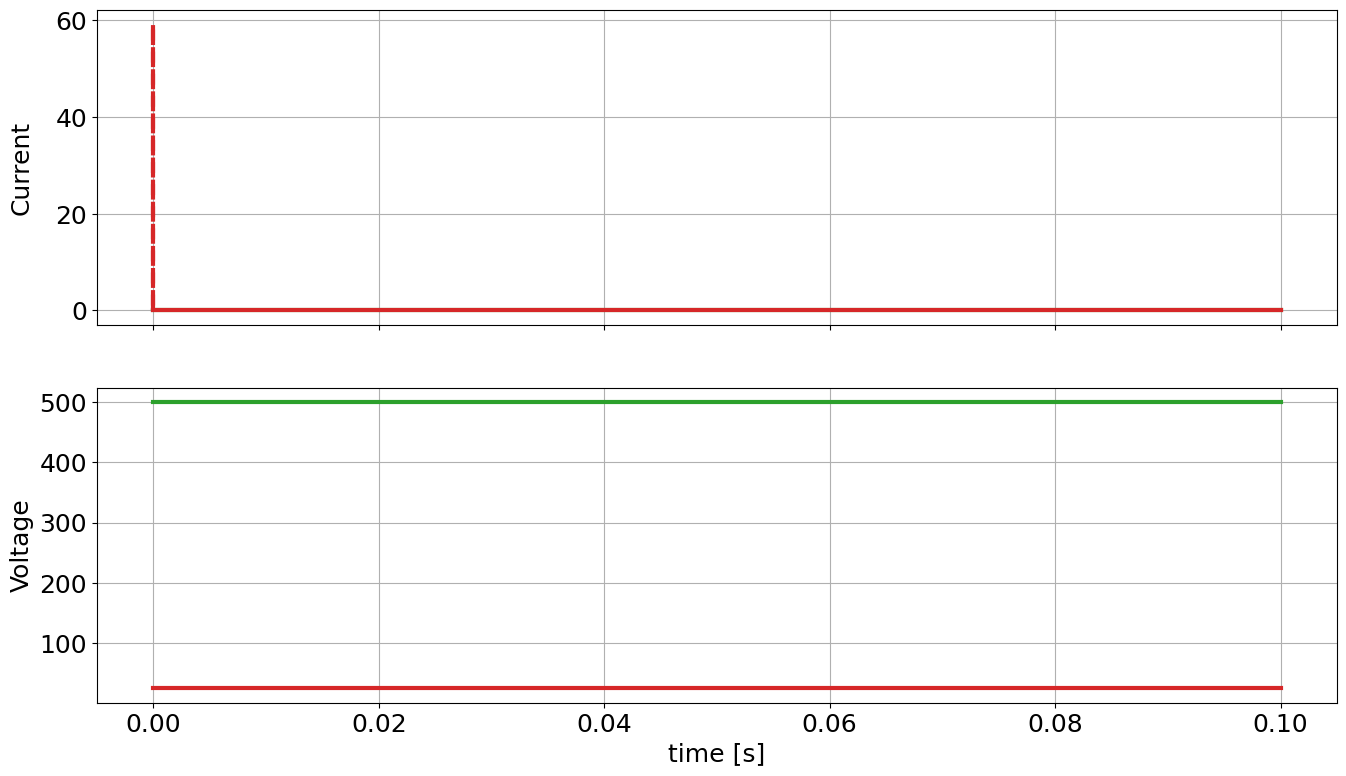

In [61]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()


# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='I', axis=ax[0])
    g.add_line(var_type='_x', var_name='V', axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='G', axis=ax[1])
    g.add_line(var_type='_u', var_name='T', axis=ax[1])


ax[0].set_ylabel('Current')
ax[1].set_ylabel('Voltage')
ax[1].set_xlabel('time [s]')

u0 = np.zeros((2,1))
for i in range(200):
    simulator.make_step(u0)
    
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig

In [58]:
u0 = mpc.make_step(x0)
sim_graphics.clear()


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      642
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      141

Total number of variables............................:      208
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      194
                     variables with only upper bounds:        0
Total number of equality constraints.................:      162
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

CasADi -  WARNING("S:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_g failed: Inf detected for output g, at (row 141, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_g failed: Inf detected for output g, at (row 141, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_g failed: Inf detected for output g, at (row 141, col 0).") [.../casadi/core/oracle_function.cpp:265]


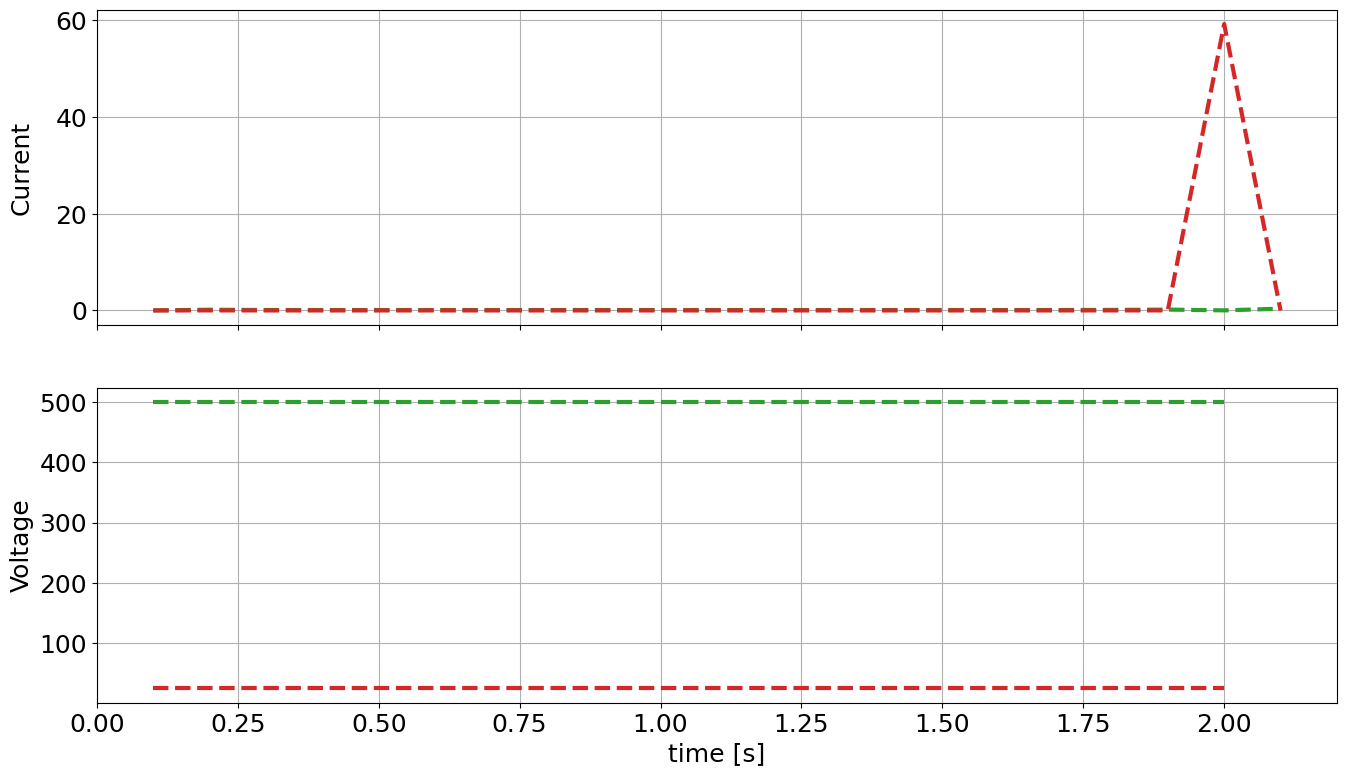

In [59]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig